# Movie Recommendations

MovieLens is a research site run by GroupLens Research at the University of Minnesota. MovieLens (https://movielens.org/) shares with community several datasets containing user's ratings of some movies. 

Our goal is to build a recommender system that will recommend user some movies that he probably would like to see based on his already collected ratings of other movies. For the purposes of this exercise we will focus on using Collaborative Filtering as our approach.

![alt text](https://cdn.codecentric.de/20210310095830/Fig1-1.png)





# Libraries

In [1]:
#Surprise is an open-source Python library for building recommender systems with explicit rating data. 
#install scikit surprise using terminal with code below

#conda install -c conda-forge scikit-surprise


In [2]:
# allows us to access dataframes
import pandas as pd

# specialized class for handling sparse matrices (compressed)
from scipy.sparse import csr_matrix

# Library for visualizing charts
import matplotlib.pylab as plt


# Gives us access to the unsupervised algorithm knn 
from sklearn.neighbors import NearestNeighbors

# Surprise is an easy-to-use Python scikit for recommender systems.
from surprise import SVD #SVD algorithm
from surprise import KNNBasic # Knn algorithm
from surprise import Dataset # Utility for loading datasets
from surprise import Reader # Allows surprise to interpret the ratings
from surprise.model_selection import cross_validate # cross validation utility


# Exploration

In [3]:
# https://grouplens.org/datasets/movielens
# https://files.grouplens.org/datasets/movielens/ml-latest-small.zip

movies_df = pd.read_csv("data/ml-latest-small/movies.csv")
movies_df = movies_df.drop_duplicates() #remove duplicate rows
movies_df.dtypes

movieId     int64
title      object
genres     object
dtype: object

In [4]:
movies_df.shape

(9742, 3)

In [5]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings_df = pd.read_csv("data/ml-latest-small/ratings.csv")
ratings_df = ratings_df.drop_duplicates() #remove duplicate rows
ratings_df.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [7]:
ratings_df.shape

(100836, 4)

In [8]:
#understand unique counts for the dataset

num_users = len(ratings_df.userId.unique())
num_items = len(ratings_df.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 610 unique users and 9724 unique movies in this data set


In [9]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Text(0.5, 1.0, 'Count of Movie Ratings per User Id')

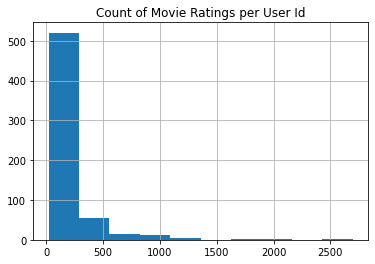

In [10]:
#How many ratings per User ID do we have?

ratings_df[['userId','movieId']].groupby(['userId']).count().hist()
plt.title("Count of Movie Ratings per User Id")


#most of the user have XX number of ratings

In [11]:
ratings_df[['userId','movieId']].groupby(['userId']).count().describe()

#there are 610 unique users
#what else can we say about the users?

,movieId
count,610.000000
mean,165.304918
std,269.480584
min,20.000000
25%,35.000000
50%,70.500000
75%,168.000000
max,2698.000000


Text(0.5, 1.0, 'Count of User Ratings per Movie Id')

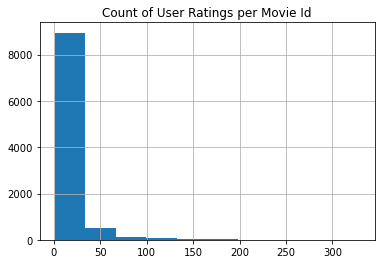

In [12]:
#How many user ratings per movie id do we have

ratings_df[['userId','movieId']].groupby(['movieId']).count().hist()
plt.title("Count of User Ratings per Movie Id")

In [13]:
ratings_df[['userId','movieId']].groupby(['movieId']).count().describe()

,userId
count,9724.000000
mean,10.369807
std,22.401005
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,329.000000


In [14]:
# based on this we can identify a threshold for amount of ratings to use per user/movie 
# ie. what is a popular movie? an active user? 
# Feel free to make this more or less restrictive as your model requires

<AxesSubplot:title={'center':'Count of Rating Score'}>

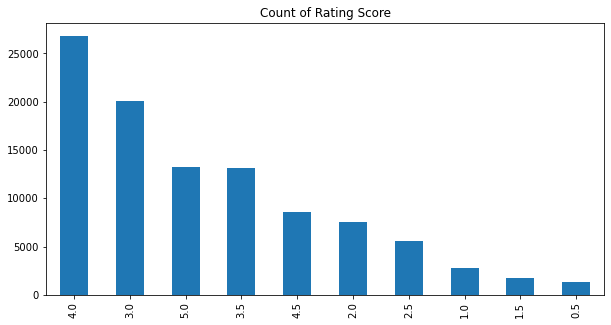

In [15]:
#look at ratings distribution

ratings_df['rating'].value_counts().plot.bar(title="Count of Rating Score",figsize=(10,5))

#what can we say about the ratings scores?

# Preprocessing

In [16]:
# Given some of our findings, let's try to optimize our dataset by filtering to only the data that we need

#why do we do this? #this is the minimum number of ratings per movie

popularity_thres = 1
movie_rating_cnt_df = ratings_df[['rating','movieId']].groupby(['movieId']).count()
popular_movies_df = movie_rating_cnt_df[movie_rating_cnt_df['rating']>=popularity_thres]


filtered_pop_movies_df = ratings_df[ratings_df.movieId.isin(popular_movies_df.index.values)]
print('shape of original ratings data: ', ratings_df.shape)
print('shape of ratings data after dropping unpopular movies: ', filtered_pop_movies_df.shape)

shape of original ratings data:  (100836, 4)
shape of ratings data after dropping unpopular movies:  (100836, 4)


In [17]:
#filtering for active users
ratings_thres = 1 
#max_thres= 500

active_users_cnt_df = ratings_df[['userId','movieId']].groupby(['userId']).count()
active_users_df = active_users_cnt_df[active_users_cnt_df['movieId']>=ratings_thres]

#active_users_df = active_users_cnt_df[(active_users_cnt_df['movieId']>=ratings_thres)& (active_users_cnt_df['movieId']< max_thres) ]

#display(active_users_df) 

filtered_popular_active_df = filtered_pop_movies_df[filtered_pop_movies_df.index.isin(active_users_df.index.values)]
print('shape of original ratings data: ', filtered_pop_movies_df.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', filtered_popular_active_df.shape)

shape of original ratings data:  (100836, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (610, 4)


In [18]:
filtered_popular_active_df.head()

,userId,movieId,rating,timestamp
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400


In [19]:
# Let's transform this into a movie-user pivot table
# Let's join them up first using a left join operation on movieId

filtered_movie_ratings_merged_df = pd.merge(filtered_popular_active_df,movies_df, how='left', on=['movieId'])
filtered_movie_ratings_merged_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
1,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
2,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
3,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
4,1,70,3.0,964982400,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller


In [20]:
filtered_movie_ratings_merged_df.shape

(610, 6)

In [21]:
# Now let's pivot the dataframe such that it will have movieId as the index, and userId as columns
filtered_movie_ratings_df = pd.pivot(filtered_movie_ratings_merged_df,index='movieId', columns='userId', values='rating').fillna(0)
filtered_movie_ratings_df.head()


userId,1,2,3,4,5,6
movieId,,,,,,
1,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,4.0
3,4.0,0.0,0.0,0.0,0.0,5.0
4,0.0,0.0,0.0,0.0,0.0,3.0
5,0.0,0.0,0.0,0.0,0.0,5.0


In [22]:
#Matrices that contain mostly zero values are called sparse,
#distinct from matrices where most of the values are non-zero, called dense.

#It is computationally expensive to represent and work with sparse matrices as though they are dense, 
#and much improvement in performance can be achieved by using representations and operations 
#that specifically handle the matrix sparsity.

#Instead of storing zeroes with non-zero elements, we only store non-zero elements. 
#This means storing non-zero elements with triples- (Row, Column, value).

# Now given that this is a sparse matrix, we will use scipy which has a matrix class
# that is optimized to handle sparse matrix objects

#The function csr_matrix() is used to create a sparse matrix of compressed sparse row format 
#whereas csc_matrix() is used to create a sparse matrix of compressed sparse column format.



movie_ratings_mat = csr_matrix(filtered_popular_active_df.values)
movie_ratings_mat

# this will be used as input to the model

<610x4 sparse matrix of type '<class 'numpy.float64'>'
	with 2440 stored elements in Compressed Sparse Row format>

# Memory-based Approach
## Using KNN to estimate distance

Here we will use KNN, which is an unsupervised learning model, in which a data point is classified by a majority vote of its neighbors, with the data point being assigned to the class most common amongst its k-nearest neighbors, as measured by a distance function (these can be of any kind depending upon your data being continuous or categorical). If k = 1, then the data point is simply assigned to the class of its nearest neighbor—i.e., itself.

In [23]:
# Metric is the distance algorithm to be used. You can find more choices here: 
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric

# algorithm is the type of tree search used by the model
# neighbors it the amount of neighbors identified
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

# fit
model_knn.fit(movie_ratings_mat)


NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

KNN does not make any assumptions on the underlying data distribution but it relies on item feature similarity. When KNN makes inference about a movie, KNN will calculate the “distance” between the target movie and every other movie in its database, then it ranks its distances and returns the top K nearest neighbor movies as the most similar movie recommendations.

![alt text](https://miro.medium.com/max/975/1*OyYyr9qY-w8RkaRh2TKo0w.png)

In [24]:
# Let's try it out
fav_movie = "Toy"
print('You have input movie:', fav_movie)

# find movies that "match" title
movie_matches_df = filtered_movie_ratings_merged_df[filtered_movie_ratings_merged_df['title'].str.contains(fav_movie)]  
movie_matches_df

You have input movie: Toy


,userId,movieId,rating,timestamp,title,genres
142,1,2253,2.0,964981775,Toys (1992),Comedy|Fantasy
515,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


# Let's Recommend!

In [25]:
print("Let's start making recommendations!...")

if(movie_matches_df is  None):
    print("No Matching movies :(")
else:
    # Indicate the top recommendations we want to get (how many neighbors should we find?)
    top_recommendations = 10

    movie_idx= movie_matches_df.iloc[0]['movieId'] # select the first movie in the list, get the movie Id
    
    # get the dataframe index from the movieId
    movie_idx = filtered_movie_ratings_merged_df[filtered_movie_ratings_merged_df['movieId'] == movie_idx].index[0]

    # model will return a list of distances and indices
    distances , indices = model_knn.kneighbors(movie_ratings_mat[movie_idx],n_neighbors=top_recommendations+1)    

    # transform the result into a list
    rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
    recommend_frame = [] #let's create an empty list
 
    # we will iterate thru the results and add them to the list
    for val in rec_movie_indices:
        
        # we get the movie id
        movie_idx = filtered_movie_ratings_merged_df.iloc[val[0]]['movieId']
        # convert into an index, we will this use to get the movie title
        idx = filtered_movie_ratings_merged_df[filtered_movie_ratings_merged_df['movieId'] == movie_idx].index
        # take the movie title together with the computed "distance". This distance is how far the movies are from the 'target' movie
        recommend_frame.append({'Title':filtered_movie_ratings_merged_df.iloc[idx]['title'].values[0],'Distance':val[1]})

    # place resulting list inside a dataframe
    df = pd.DataFrame(recommend_frame,index=range(1,top_recommendations+1))
    display(df.sort_values("Distance")) #sort by distance to get the top 10


Let's start making recommendations!...


,Title,Distance
8,"Few Good Men, A (1992)",1.110223e-16
9,Toys (1992),1.110223e-16
10,Strangers on a Train (1951),1.110223e-16
6,Piranha (1978),2.220446e-16
7,Rush Hour (1998),2.220446e-16
5,Edward Scissorhands (1990),8.881784e-16
4,Saboteur (1942),1.221245e-15
3,Willow (1988),1.998401e-15
2,Life Is Beautiful (La Vita è bella) (1997),2.886580e-15
1,Pecker (1998),3.108624e-15


In [26]:
# Let's use surprise library to get a measure of our knn model's RMSE metric
# The Reader class is used to parse a file containing ratings.
# A reader is still needed but only the rating_scale param is required.

reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(filtered_movie_ratings_merged_df[['userId', 'movieId', 'rating']], reader)

# We'll train a knn model in surprise using our same data set
knnbasic = KNNBasic()

# Run 5-fold cross-validation and print results.
knn_results = cross_validate(knnbasic, data, measures=['RMSE'], cv=5, verbose=True)
knn_results


# Smaller RMSE means our model is able to give better recommendation

#how do we try other knn models?

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1483  1.4105  1.3423  1.4721  1.4831  1.3713  0.1223  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([1.14833663, 1.41053179, 1.34234833, 1.47208677, 1.48310248]),
 'fit_time': (0.0006048679351806641,
  0.00011801719665527344,
  0.0003371238708496094,
  0.00010991096496582031,
  0.00016999244689941406),
 'test_time': (0.0006587505340576172,
  0.0005629062652587891,
  0.0006427764892578125,
  0.0005228519439697266,
  0.0005578994750976562)}

# Model based approach

To Make things much more easier, we will be using the Surprise scikit which specializes in recommender models.

Continuing our Collaborative Filtering example, we will now use a model based approach via SVD (Singular Value Decomposition), as popularized by Simon Funk during the Netflix Prize. When baselines are not used, this is equivalent to Probabilistic Matrix Factorization [salakhutdinov2008a].

Supplementary reading for SVD: https://towardsdatascience.com/understanding-singular-value-decomposition-and-its-application-in-data-science-388a54be95d

SVD vs PCA https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491

"From a simplified perspective, PCA transforms data linearly into new properties that are not correlated with each other. For ML, positioning PCA as feature extraction may allow us to explore its potential better than dimension reduction.
What is the difference between SVD and PCA? SVD gives you the whole nine-yard of diagonalizing a matrix into special matrices that are easy to manipulate and to analyze. It lay down the foundation to untangle data into independent components. PCA skips less significant components. Obviously, we can use SVD to find PCA by truncating the less important basis vectors in the original SVD matrix"

In [27]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(filtered_movie_ratings_merged_df[['userId', 'movieId', 'rating']], reader)

# Use the famous SVD algorithm
algo = SVD()

# Run 5-fold cross-validation and print results.
svd_results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)
svd_results

# Smaller RMSE means our model is able to give better recommendation

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0686  1.1749  1.1596  1.2073  1.1929  1.1606  0.0488  
Fit time          0.03    0.02    0.02    0.02    0.02    0.02    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([1.06856265, 1.1748615 , 1.15959573, 1.20725767, 1.19289266]),
 'fit_time': (0.025419235229492188,
  0.023420333862304688,
  0.023044824600219727,
  0.023720979690551758,
  0.022577285766601562),
 'test_time': (0.0009660720825195312,
  0.00043392181396484375,
  0.0004189014434814453,
  0.0005099773406982422,
  0.0004076957702636719)}

# Let's try to predict

In [28]:
# User rated 4
uid = str(1)  

# Movie: Grumpier Old Men (1995)
iid = str(3)  

#Get the prediction for the specific users and movie.
print("Prediction for rating: ")
pred = algo.predict(uid, iid, r_ui=4, verbose=True)
pred

Prediction for rating: 
user: 1          item: 3          r_ui = 4.00   est = 3.85   {'was_impossible': False}


Prediction(uid='1', iid='3', r_ui=4, est=3.8514344262295084, details={'was_impossible': False})

In [29]:
# Our model was able to predict that the user (1) will rate the movie (3) a score of 3.7843 (4)

# Let's compare the two using RMSE

In [30]:
metric_df = pd.DataFrame()
metric_df['knn'] = knn_results['test_rmse']
metric_df['svd'] = svd_results['test_rmse']

tmp_dict1 = {'knn':metric_df['knn'].mean(),'svd':metric_df['svd'].mean()}
tmp_dict2 = {'knn':metric_df['knn'].std(),'svd':metric_df['svd'].std()}

metric_df = metric_df.append(tmp_dict1,ignore_index=True)
metric_df = metric_df.append(tmp_dict2,ignore_index=True)
metric_df.index = ['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5','Mean','Std']
metric_df


,knn,svd
Fold 1,1.148337,1.068563
Fold 2,1.410532,1.174862
Fold 3,1.342348,1.159596
Fold 4,1.472087,1.207258
Fold 5,1.483102,1.192893
Mean,1.371281,1.160634
Std,0.136700,0.054532


# Top n predictions and the hit rate

We want to be able to generate the top N predictions using the two models and calculate hit rate.

After generating top n, if one recommendation they actually rated, you consider it a hit.

In [31]:
from collections import defaultdict

# accept list of predictions and n of top n
#this is like our scoring algorithm for reco engines

def get_top_n(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        # top_n = is a dictionary to map rating to a userid as key
        # est = predicted rating
        # iid = movie id
        # uid = user id
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        
        # x[1] refers to the est score, which means sort highest to lowest using the rating per user
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [32]:
from surprise.model_selection import LeaveOneOut


# Let's rebuild our models
# A reader is still needed but only the rating_scale param is required.
# this indicates our rating is 1 to 5 only

reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(filtered_movie_ratings_merged_df[['userId', 'movieId', 'rating']], reader)

#Build a "leave one out" train/test split for evaluating top-N recommenders
LOOCV = LeaveOneOut(n_splits=1, random_state=1)
for train, test in LOOCV.split(data):
    LOOCVTrain = train
    LOOCVTest = test

#Save leave one out test predictions
leftoutpredictions = LOOCVTest


#And build an anti-test-set for building predictions
LOOCVAntiTestSet = LOOCVTrain.build_anti_testset()


# generate two models
knn = KNNBasic()
svd = SVD()

# fit using generated training set from data
knn.fit(LOOCVTrain)
svd.fit(LOOCVTrain)

# Then predict ratings for all pairs (u, i) that are NOT in the training set (from data)
#testset = trainset.build_anti_testset()

# generate predictions
knn_predictions = knn.test(LOOCVAntiTestSet)
svd_predictions = svd.test(LOOCVAntiTestSet)



Computing the msd similarity matrix...
Done computing similarity matrix.


In [33]:
svd_predictions

[Prediction(uid=1, iid=318, r_ui=3.8245033112582782, est=3.9795785135720263, details={'was_impossible': False}),
 Prediction(uid=1, iid=1704, r_ui=3.8245033112582782, est=4.071702590229023, details={'was_impossible': False}),
 Prediction(uid=1, iid=6874, r_ui=3.8245033112582782, est=4.330219523037828, details={'was_impossible': False}),
 Prediction(uid=1, iid=8798, r_ui=3.8245033112582782, est=4.462588659046912, details={'was_impossible': False}),
 Prediction(uid=1, iid=46970, r_ui=3.8245033112582782, est=4.275543734655874, details={'was_impossible': False}),
 Prediction(uid=1, iid=48516, r_ui=3.8245033112582782, est=4.23892364766546, details={'was_impossible': False}),
 Prediction(uid=1, iid=58559, r_ui=3.8245033112582782, est=4.548552477797166, details={'was_impossible': False}),
 Prediction(uid=1, iid=60756, r_ui=3.8245033112582782, est=4.203719215083974, details={'was_impossible': False}),
 Prediction(uid=1, iid=68157, r_ui=3.8245033112582782, est=4.418688645404296, details={'was_i

In [34]:
# generate top ten recommendations based on users NOT in the training set
knn_top_n = get_top_n(knn_predictions, n=10)
svd_top_n = get_top_n(svd_predictions, n=10)

# Print the recommended items for each user
print("")
print("top n recommendations for knn")
for uid, user_ratings in knn_top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

print("")
print("top n recommendations for svd")   
for uid, user_ratings in svd_top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])


top n recommendations for knn
1 [60756, 80906, 89774, 106782, 122882, 131724, 849, 2851, 4518, 5181]
2 [101, 151, 157, 163, 216, 231, 260, 362, 527, 596]
3 [101, 151, 157, 163, 216, 231, 260, 333, 362, 596]
4 [101, 151, 157, 163, 216, 231, 362, 596, 923, 940]
5 [101, 151, 157, 163, 216, 231, 260, 362, 919, 923]
6 [101, 151, 157, 163, 216, 231, 260, 333, 362, 596]

top n recommendations for svd
1 [232, 215, 4239, 2186, 2, 7991, 1250, 1834, 1225, 162]
2 [6835, 2791, 1084, 2150, 596, 247, 7899, 7991, 260, 2174]
3 [596, 594, 122882, 1179, 80906, 125, 457, 1954, 3441, 2654]
4 [4518, 22, 7991, 1136, 26409, 333, 2716, 2947, 2427, 923]
5 [2395, 6835, 2843, 2329, 3508, 3255, 89, 2459, 1587, 4239]
6 [122882, 3024, 527, 608, 2078, 593, 2944, 910, 1188, 1282]


In [35]:
# utility function to get the movie title based on the movieId
def get_title_from_id(idx):
    return filtered_movie_ratings_merged_df[filtered_movie_ratings_merged_df['movieId']==idx]['title'].values[0]

In [36]:
# Print the recommended items for each user
print("")
print("top n recommendations for knn")
for uid, user_ratings in knn_top_n.items():
    print(uid, [get_title_from_id(iid) for (iid, _) in user_ratings])

print("")
print("top n recommendations for svd")   
for uid, user_ratings in svd_top_n.items():
    print(uid, [get_title_from_id(iid) for (iid, _) in user_ratings])


top n recommendations for knn
1 ['Step Brothers (2008)', 'Inside Job (2010)', 'Warrior (2011)', 'Wolf of Wall Street, The (2013)', 'Mad Max: Fury Road (2015)', 'The Jinx: The Life and Deaths of Robert Durst (2015)', 'Escape from L.A. (1996)', 'Saturn 3 (1980)', 'The Lair of the White Worm (1988)', 'Hangar 18 (1980)']
2 ['Bottle Rocket (1996)', 'Rob Roy (1995)', 'Canadian Bacon (1995)', 'Desperado (1995)', 'Billy Madison (1995)', 'Dumb & Dumber (Dumb and Dumber) (1994)', 'Star Wars: Episode IV - A New Hope (1977)', 'Jungle Book, The (1994)', "Schindler's List (1993)", 'Pinocchio (1940)']
3 ['Bottle Rocket (1996)', 'Rob Roy (1995)', 'Canadian Bacon (1995)', 'Desperado (1995)', 'Billy Madison (1995)', 'Dumb & Dumber (Dumb and Dumber) (1994)', 'Star Wars: Episode IV - A New Hope (1977)', 'Tommy Boy (1995)', 'Jungle Book, The (1994)', 'Pinocchio (1940)']
4 ['Bottle Rocket (1996)', 'Rob Roy (1995)', 'Canadian Bacon (1995)', 'Desperado (1995)', 'Billy Madison (1995)', 'Dumb & Dumber (Dumb an

In [37]:
# HIT RATE - This is usually used for top n recomendation systems, since we're not really predicting against anything
# Tries to measure how many movies did we predict are in the top movies of a user we left out,
# are also in the top n movies we predicted

# Generate the top n recommendation for a user and compare them to those the user has rated, liked or watched.
# If they match then increase the hit rate by 1, do this for the complete training set to get the hit rate.
# The higher the better, but if its very low or zero, it means we need to use more data 

def hitrate(topNpredictions,leftoutpredictions):
    
    # iterate per user
    # get movie id
    # iterate thru each movie id
    # how many hits?
    # return hitrate per user
    
    userHitRates = [] # create list of user hit rates
   
    leftoutMovieIds_list = []
    
    # iterate per user per movieId
    for leftout in leftoutpredictions:
        uid=leftout[0]
        leftoutmovieid=leftout[1]
    
        print("uid: ", uid)
        print("watched: ",leftoutmovieid)
        
        

        predictedMovies_list = [] 
        for predMovieId, predRating in knn_top_n[uid]:
            predictedMovies_list.append(predMovieId)
        
        print(predictedMovies_list)
        hits = len(set([leftoutmovieid]).intersection(predictedMovies_list))
        total = len(predictedMovies_list)
        userHitRate = hits/total
        
        userhitRate_dict = {"uid":uid,"userhitrate":userHitRate}
        userHitRates.append(userhitRate_dict)
    
    return pd.DataFrame(userHitRates)

In [38]:
knn_top_n[3]

[(101, 5),
 (151, 5),
 (157, 5),
 (163, 5),
 (216, 5),
 (231, 5),
 (260, 5),
 (333, 5),
 (362, 5),
 (596, 5)]

knn_top_n.items()

In [39]:
# Let's append this to our metric dataframe
final_metric_df = metric_df
final_metric_df.index = ['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5','Mean','Std']
print("Metric Comparison (RSME)")
display(final_metric_df)

Metric Comparison (RSME)


,knn,svd
Fold 1,1.148337,1.068563
Fold 2,1.410532,1.174862
Fold 3,1.342348,1.159596
Fold 4,1.472087,1.207258
Fold 5,1.483102,1.192893
Mean,1.371281,1.160634
Std,0.136700,0.054532


In [40]:
print("SVD hitrate metrics")
hitrate(svd_top_n, leftoutpredictions)

SVD hitrate metrics
uid:  1
watched:  661
[60756, 80906, 89774, 106782, 122882, 131724, 849, 2851, 4518, 5181]
uid:  2
watched:  71535
[101, 151, 157, 163, 216, 231, 260, 362, 527, 596]
uid:  3
watched:  1302
[101, 151, 157, 163, 216, 231, 260, 333, 362, 596]
uid:  4
watched:  1136
[101, 151, 157, 163, 216, 231, 362, 596, 923, 940]
uid:  5
watched:  153
[101, 151, 157, 163, 216, 231, 260, 362, 919, 923]
uid:  6
watched:  16
[101, 151, 157, 163, 216, 231, 260, 333, 362, 596]


,uid,userhitrate
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0
5,6,0.0


In [41]:
print("KNN hitrate metrics")
hitrate(knn_top_n, leftoutpredictions)

KNN hitrate metrics
uid:  1
watched:  661
[60756, 80906, 89774, 106782, 122882, 131724, 849, 2851, 4518, 5181]
uid:  2
watched:  71535
[101, 151, 157, 163, 216, 231, 260, 362, 527, 596]
uid:  3
watched:  1302
[101, 151, 157, 163, 216, 231, 260, 333, 362, 596]
uid:  4
watched:  1136
[101, 151, 157, 163, 216, 231, 362, 596, 923, 940]
uid:  5
watched:  153
[101, 151, 157, 163, 216, 231, 260, 362, 919, 923]
uid:  6
watched:  16
[101, 151, 157, 163, 216, 231, 260, 333, 362, 596]


,uid,userhitrate
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0
5,6,0.0


# Does better RSME mean better hit rate?

# Additional References
- https://en.wikipedia.org/wiki/Collaborative_filtering
- http://recommender-systems.org/collaborative-filtering/
- https://www.geeksforgeeks.org/fuzzywuzzy-python-library/
- https://medium.com/@rishabhbhatia315/recommendation-system-evaluation-metrics-3f6739288870
- http://surpriselib.com/

## Data sets to try
- https://data.world/socialmediadata/beeradvocate
- http://eigentaste.berkeley.edu/dataset/
- https://cseweb.ucsd.edu/~jmcauley/datasets.html